In [14]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.linalg import block_diag
import cvxpy as cp
import networkx as nx

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Adjacency matrix of network graph

In [15]:
A = np.array(
    [[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0],
     [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
     [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0],
     [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
     [0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
     [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
     [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
     [0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]]
)

# Graph visualization

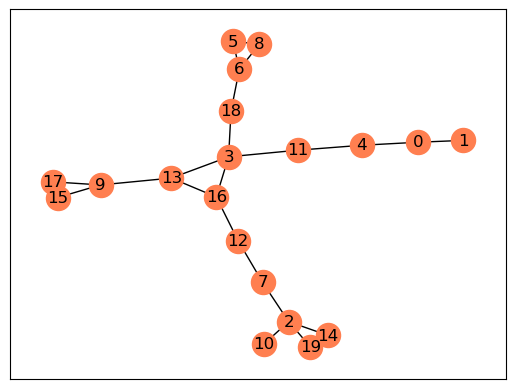

In [16]:
G = nx.from_numpy_array(A)
nx.draw_networkx(G, node_color="coral")

# Problem formulation

$K$ — number of agents, $E$ — number of clusters (we consider $E = K$), $N_e$ — neighbours of e-th agent

$$
\begin{align*}
\min_{w_k \in \Pi_k} & \sum\limits_{k=1}^{K} w_k^\top R_k w_k + r_k^\top w_k \\
\mathrm{s.t.} & \sum\limits_{k \in N_e} B_{e, k} w_k = b_e, \quad \forall e = 1, \ldots, E
\end{align*}
$$

$R_k \in \mathbb{R}^{Q_k \times Q_k}$ is positive-definite and well conditioned (i.e., the difference between maximum and minimum singular values is not very large)

$r_k \in \mathbb{R}^{Q_k}$ is randomly generated with each element uniformly chosen from (-2, -1, 0, 1, 2)

$B_{e, k} \in \mathbb{R}^{S_e \times Q_k}$ (with $S_e = 1$) is a randomly genereated row vector with elements uniformly chosen from (-2, -1, 0, 1, 2)

$b_e$ is a scalar uniformly chosen from (-1, 0, 1)

$\Pi_k$ is a cube $\prod\limits_{i = 1}^{Q_k}[-1, 1]$

For methods without cluster communication we consider a similar problem, i.e. $B_{e, k}$ are stacked into block columns and $b_e$ are stacked into a column

$$
\begin{align*}
\min_{w_k \in \Pi_k} & \sum\limits_{k=1}^{K} w_k^\top R_k w_k + r_k^\top w_k \\
\mathrm{s.t.} & \sum\limits_{k=1}^{K} \hat{B}_{k} w_k = \hat{b}
\end{align*}
$$

In [124]:
K = 20
E = K
S_e = 1
Q_k = 10

R_array = []
for k in range(K):
    #R_k = np.random.randn(Q_k, Q_k)
    #R_k = R_k.T @ R_k
    #R_k = 2 * np.diag(np.ones(Q_k), k = 0) + np.diag(np.ones(Q_k-1), k = 1) + np.diag(np.ones(Q_k-1), k = -1)
    #ev = np.linalg.eigvals(R_k)
    #eva = [abs(x) for x in ev]
    #print(max(eva) - min(eva))
    #R_k = 1.5 * np.identity(Q_k)
    R_k = np.diag(np.linspace(1, 5, Q_k))
    R_array.append(R_k)

R_array = np.array(R_array)

r_array = []
for k in range(K):
    r_k = np.random.randint(low = -2, high = 3, size = Q_k)
    r_array.append(r_k)

b_e = np.random.randint(low = -1, high = 2, size = K)

A_I = A + np.identity(K)
N = [int(A_I.sum(axis=1)[i]) for i in range(K)]

B_matrix = []
for e in range(K):
    B_array = []
    for k in range(K):
        if k in np.nonzero(A_I[e])[0]:
            B_ek = np.random.randint(low = -2, high = 3, size = (S_e, Q_k))
            B_array.append(B_ek)
        else: 
            B_array.append(np.zeros((S_e, Q_k)))
            
    B_matrix.append(B_array)

B_stack_matrix = []
for k in range(K):
    B_stack_matrix.append(np.vstack(tuple([B_matrix[e][k] for e in range(K)])))

In [125]:
from methods import Model

In [126]:
model = Model()
model.get_network(A)
model.get_function(R_array, r_array)
model.get_constraints(B_stack_matrix, b_e)

cluster_model = Model()
cluster_model.get_network(A)
cluster_model.get_function(R_array, r_array)
cluster_model.get_constraints(B_matrix, b_e)

# CVXPY

In [127]:
w = cp.Variable(Q_k * K)

R = block_diag(*R_array)
r = np.hstack(tuple(r_array))

func = cp.quad_form(w, R) + r @ w

constraints = [w >= -100,
               w <= 100]

for e in range(K):
    constraints.append(np.hstack(tuple(B_matrix[e])) @ w == b_e[e])

obj = cp.Minimize(func)

prob = cp.Problem(obj, constraints)
prob.solve()
w_opt = w.value

# Alghunaim

In [128]:
from methods import Alghunaim

In [129]:
alghunaim_coupled = Alghunaim(cluster_model)

alghunaim_coupled.get_n_iter(n_iter=1000)
alghunaim_coupled.get_start_point(wm1=np.zeros(Q_k * K), ym1=np.zeros(sum(N)))
alghunaim_coupled.get_step_sizes(mu_w=0.1, mu_y=0.2)

w_i_PDCD, y_i_PDCD = alghunaim_coupled.solve(coupled=True)

In [130]:
alghunaim = Alghunaim(model)

alghunaim.get_n_iter(n_iter=1000)
alghunaim.get_start_point(wm1=np.zeros(Q_k * K), ym1=np.zeros(K * E))
alghunaim.get_step_sizes(mu_w=0.1, mu_y=0.2)

w_i_PDD, y_i_PDD = alghunaim.solve(coupled=False)

# Huang

In [131]:
from methods import Huang

In [132]:
huang_triggered = Huang(model)

huang_triggered.get_n_iter(n_iter=1000)
huang_triggered.get_start_point(x0=np.zeros(Q_k * K), lmbd0=np.zeros(K * E), s0=np.zeros(K * E))
huang_triggered.get_step_sizes(k_c=10)

w_i_ET, C_ET = huang_triggered.solve(event_triggered=True)
w_i_unique, C_s_unique = huang_triggered.get_communications(w_i_ET, C_ET)

In [133]:
w_i_P, C_P = huang_triggered.solve(event_triggered=False)

# Comparison

Text(0, 0.5, 'Squared error')

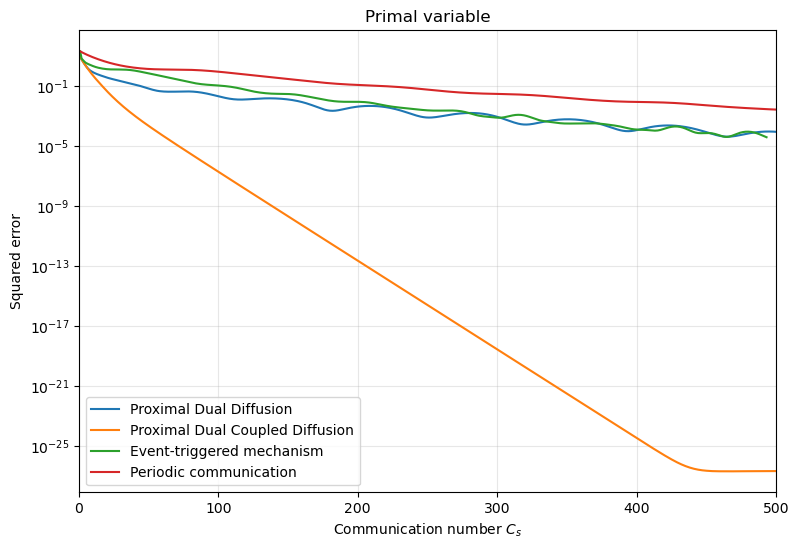

In [134]:
plt.figure(figsize=(9, 6))

plt.plot(range(w_i_PDD.shape[0]), [np.linalg.norm(w_i_PDD[i] - w_opt)**2 for i in range(w_i_PDD.shape[0])], 
         label = 'Proximal Dual Diffusion')

plt.plot(range(w_i_PDCD.shape[0]), [np.linalg.norm(w_i_PDCD[i] - w_opt)**2 for i in range(w_i_PDCD.shape[0])], 
         label = 'Proximal Dual Coupled Diffusion')

plt.plot(C_s_unique, [np.linalg.norm(w_i_unique[k] - w_opt)**2 for k in range(len(w_i_unique))], label="Event-triggered mechanism")

plt.plot(range(w_i_P.shape[0]), [np.linalg.norm(w_i_P[k] - w_opt)**2 for k in range(w_i_P.shape[0])], label="Periodic communication")

plt.xlim(0, 500)
plt.legend()
plt.grid(alpha = 0.3)
plt.yscale('log')
plt.title("Primal variable")
plt.xlabel("Communication number $C_s$")
plt.ylabel("Squared error")

# Carli

In [135]:
from methods import Carli

In [136]:
carli = Carli(model)

carli.get_n_iter(n_iter=1000)
carli.get_start_point(x0=np.zeros(Q_k * K), l0=np.zeros(K * E))

w_i_ADMM, y_i_ADMM = carli.solve(alpha=1e-3, tau=10)

Text(0, 0.5, 'Squared error')

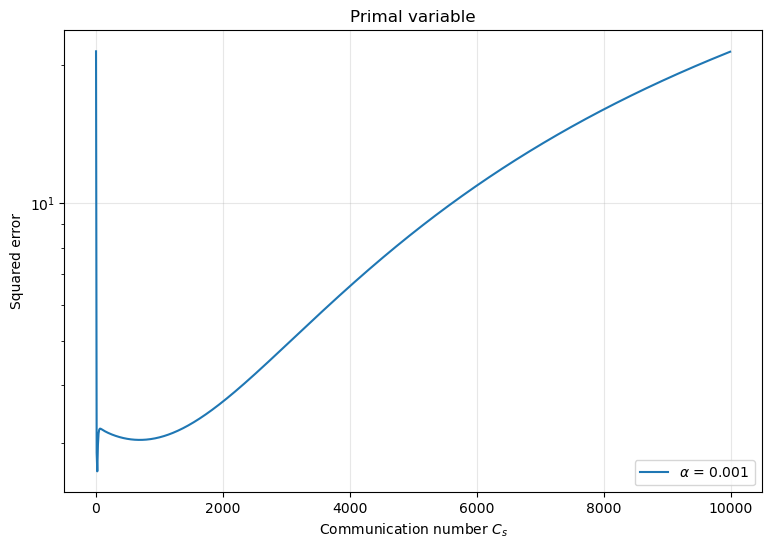

In [137]:
plt.figure(figsize=(9, 6))

plt.plot(range(0, 10 * w_i_ADMM.shape[0], 10), [np.linalg.norm(w_i_ADMM[k] - w_opt)**2 for k in range(w_i_ADMM.shape[0])], label=f"$\\alpha$ = {1e-3}")

#plt.xlim(0, 500)
plt.legend()
plt.grid(alpha = 0.3)
plt.yscale('log')
plt.title("Primal variable")
plt.xlabel("Communication number $C_s$")
plt.ylabel("Squared error")

Text(0, 0.5, 'Squared error')

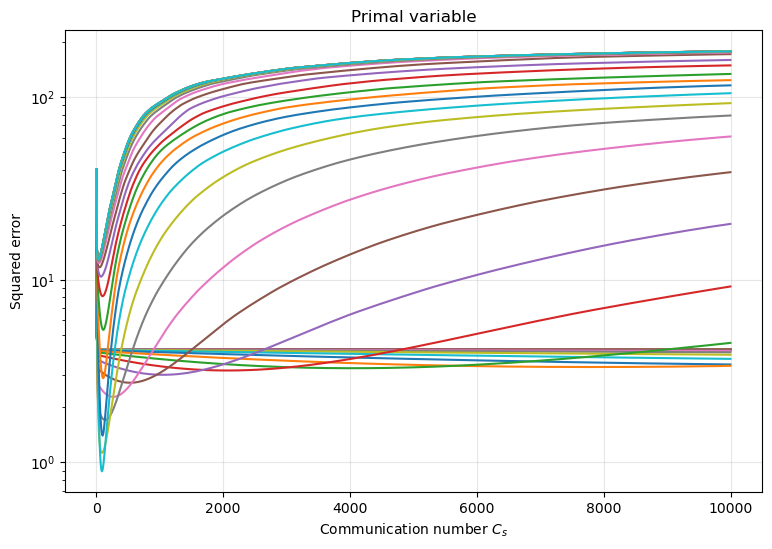

In [29]:
plt.figure(figsize=(9, 6))

for alpha in np.logspace(-10, 4):
    w_i_ADMM, y_i_ADMM = carli.solve(alpha=alpha, tau=10)
    plt.plot(range(0, 10 * w_i_ADMM.shape[0], 10), [np.linalg.norm(w_i_ADMM[k] - w_opt)**2 for k in range(w_i_ADMM.shape[0])], label=f"$\\alpha$ = {alpha}")

#plt.xlim(0, 500)
#plt.legend()
plt.grid(alpha = 0.3)
plt.yscale('log')
plt.title("Primal variable")
plt.xlabel("Communication number $C_s$")
plt.ylabel("Squared error")

We see that there is no convergence for any $\alpha$ values. Actually we don't know what this is related to, but we assume that it's about $\arg\min$ subproblem.

# Salim

In [138]:
from methods import Salim

In [139]:
salim = Salim(model)

salim.get_n_iter(1000)
salim.get_start_point(x0=np.zeros(Q_k * K))
salim.get_params()

w_i_Salim = salim.solve()

Text(0, 0.5, 'Squared error')

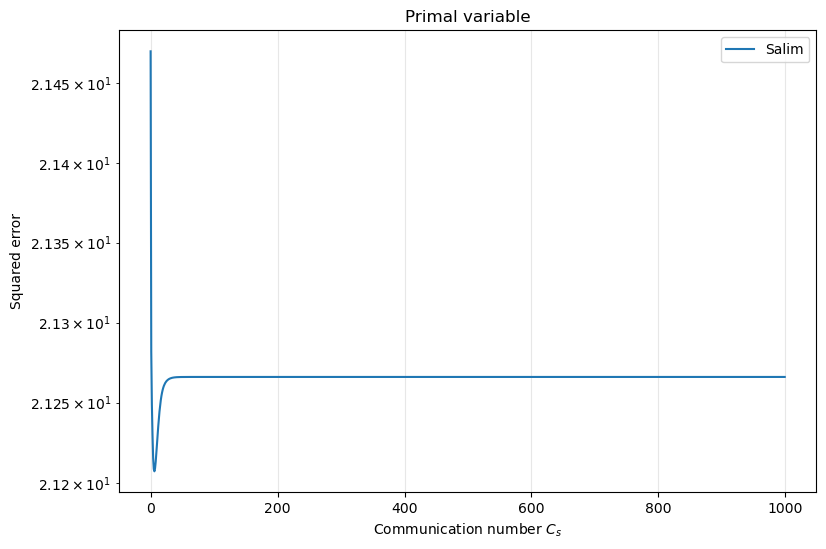

In [140]:
plt.figure(figsize=(9, 6))

plt.plot(range(w_i_Salim.shape[0]), [np.linalg.norm(w_i_Salim[i] - w_opt)**2 for i in range(w_i_Salim.shape[0])], label = 'Salim')

#plt.xlim(0, 500)
plt.legend()
plt.grid(alpha = 0.3)
plt.yscale('log')
plt.title("Primal variable")
plt.xlabel("Communication number $C_s$")
plt.ylabel("Squared error")